# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

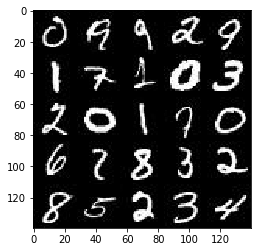

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

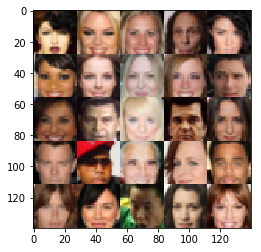

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32,[None,image_width,image_height,image_channels], name='input_real')
    z_inputs = tf.placeholder(tf.float32,[None,z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='LearningRate')
    return real_inputs,z_inputs,learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.nn.dropout(relu1, 0.9)
        
    
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2, 0.9)
    
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3, 0.9)
        

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # First fully connected layer
    alpha=0.1
    reuse_status = not is_train
    with tf.variable_scope('generator', reuse=reuse_status):
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.9)
        


        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.9)
        


        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.9)
      

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now

        out = tf.tanh(logits)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth=0.1
    g_model=generator(input_z,out_channel_dim,is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model,reuse=True)
    d_loss_real=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_logits_real) * (1-smooth) ))
    d_loss_fake=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_logits_real)))
    d_loss=d_loss_real + d_loss_fake
    g_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars=tf.trainable_variables()
    d_vars=[var for var in t_vars if var.name.startswith('discriminator')]
    g_vars=[var for var in t_vars if var.name.startswith('generator')]
    d_train_opt=tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt=tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt,g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    is_train = tf.placeholder(tf.bool)
    
    steps = 0

    print_every=10
    show_every=100
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2  

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                #_ = sess.run(g_opt, feed_dict={input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate,is_train:True})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate,is_train:False})
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

                #saver.save(sess, './checkpoints/generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.8667... Generator Loss: 0.0442
Epoch 1/2... Discriminator Loss: 3.3608... Generator Loss: 0.1739
Epoch 1/2... Discriminator Loss: 3.0384... Generator Loss: 0.2707
Epoch 1/2... Discriminator Loss: 2.9785... Generator Loss: 0.1334
Epoch 1/2... Discriminator Loss: 2.2576... Generator Loss: 0.4486
Epoch 1/2... Discriminator Loss: 2.0684... Generator Loss: 0.3719
Epoch 1/2... Discriminator Loss: 2.1155... Generator Loss: 0.4260
Epoch 1/2... Discriminator Loss: 2.4821... Generator Loss: 0.3769
Epoch 1/2... Discriminator Loss: 2.6698... Generator Loss: 0.2084
Epoch 1/2... Discriminator Loss: 2.1191... Generator Loss: 0.3842


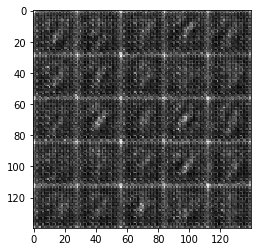

Epoch 1/2... Discriminator Loss: 2.3097... Generator Loss: 0.4850
Epoch 1/2... Discriminator Loss: 2.1757... Generator Loss: 0.3835
Epoch 1/2... Discriminator Loss: 2.3579... Generator Loss: 0.3541
Epoch 1/2... Discriminator Loss: 2.5013... Generator Loss: 0.4694
Epoch 1/2... Discriminator Loss: 2.0993... Generator Loss: 0.3249
Epoch 1/2... Discriminator Loss: 2.4263... Generator Loss: 0.4421
Epoch 1/2... Discriminator Loss: 2.1332... Generator Loss: 0.4882
Epoch 1/2... Discriminator Loss: 2.4393... Generator Loss: 0.3874
Epoch 1/2... Discriminator Loss: 1.9965... Generator Loss: 0.5282
Epoch 1/2... Discriminator Loss: 1.7971... Generator Loss: 0.6842


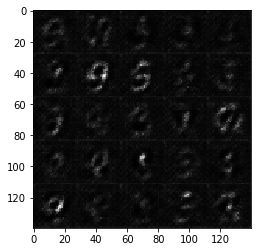

Epoch 1/2... Discriminator Loss: 2.0339... Generator Loss: 0.3763
Epoch 1/2... Discriminator Loss: 2.0393... Generator Loss: 0.6305
Epoch 1/2... Discriminator Loss: 1.9460... Generator Loss: 0.4426
Epoch 1/2... Discriminator Loss: 1.9565... Generator Loss: 0.5925
Epoch 1/2... Discriminator Loss: 1.8206... Generator Loss: 0.5005
Epoch 1/2... Discriminator Loss: 1.8091... Generator Loss: 0.3032
Epoch 1/2... Discriminator Loss: 1.5467... Generator Loss: 0.5612
Epoch 1/2... Discriminator Loss: 1.7532... Generator Loss: 0.4279
Epoch 1/2... Discriminator Loss: 1.7117... Generator Loss: 0.5395
Epoch 1/2... Discriminator Loss: 1.9312... Generator Loss: 0.4907


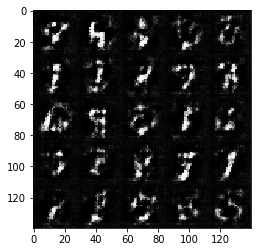

Epoch 1/2... Discriminator Loss: 1.6669... Generator Loss: 0.7049
Epoch 1/2... Discriminator Loss: 1.8865... Generator Loss: 0.5183
Epoch 1/2... Discriminator Loss: 2.1022... Generator Loss: 0.3537
Epoch 1/2... Discriminator Loss: 1.8553... Generator Loss: 0.4357
Epoch 1/2... Discriminator Loss: 1.7351... Generator Loss: 0.7038
Epoch 1/2... Discriminator Loss: 1.3396... Generator Loss: 0.6549
Epoch 1/2... Discriminator Loss: 2.1630... Generator Loss: 0.8466
Epoch 1/2... Discriminator Loss: 1.8551... Generator Loss: 0.6016
Epoch 1/2... Discriminator Loss: 1.5942... Generator Loss: 0.9274
Epoch 1/2... Discriminator Loss: 1.6146... Generator Loss: 0.6761


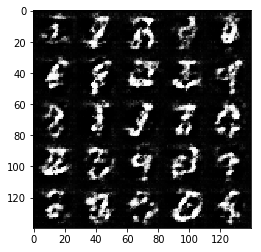

Epoch 1/2... Discriminator Loss: 1.9000... Generator Loss: 0.5297
Epoch 1/2... Discriminator Loss: 1.7266... Generator Loss: 0.5404
Epoch 1/2... Discriminator Loss: 2.0316... Generator Loss: 0.4084
Epoch 1/2... Discriminator Loss: 1.9941... Generator Loss: 0.3559
Epoch 1/2... Discriminator Loss: 2.0954... Generator Loss: 0.3740
Epoch 1/2... Discriminator Loss: 1.7781... Generator Loss: 0.6061
Epoch 1/2... Discriminator Loss: 1.5868... Generator Loss: 0.6390
Epoch 1/2... Discriminator Loss: 1.7213... Generator Loss: 0.7882
Epoch 1/2... Discriminator Loss: 1.9472... Generator Loss: 0.5096
Epoch 1/2... Discriminator Loss: 1.8679... Generator Loss: 0.7239


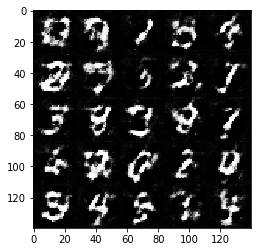

Epoch 1/2... Discriminator Loss: 1.6513... Generator Loss: 0.9037
Epoch 1/2... Discriminator Loss: 1.3289... Generator Loss: 0.9262
Epoch 1/2... Discriminator Loss: 1.8084... Generator Loss: 0.4140
Epoch 1/2... Discriminator Loss: 1.7973... Generator Loss: 0.6118
Epoch 1/2... Discriminator Loss: 1.5613... Generator Loss: 0.6996
Epoch 1/2... Discriminator Loss: 1.4233... Generator Loss: 0.5180
Epoch 1/2... Discriminator Loss: 1.6459... Generator Loss: 0.6544
Epoch 1/2... Discriminator Loss: 1.7053... Generator Loss: 0.4699
Epoch 1/2... Discriminator Loss: 1.6043... Generator Loss: 0.4288
Epoch 1/2... Discriminator Loss: 1.8526... Generator Loss: 0.4746


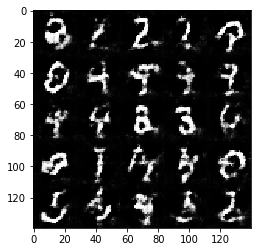

Epoch 1/2... Discriminator Loss: 1.7736... Generator Loss: 0.4823
Epoch 1/2... Discriminator Loss: 1.3542... Generator Loss: 0.5761
Epoch 1/2... Discriminator Loss: 1.5752... Generator Loss: 0.6763
Epoch 1/2... Discriminator Loss: 1.7917... Generator Loss: 0.8226
Epoch 1/2... Discriminator Loss: 1.5965... Generator Loss: 0.7655
Epoch 1/2... Discriminator Loss: 1.8087... Generator Loss: 0.6078
Epoch 1/2... Discriminator Loss: 1.5866... Generator Loss: 0.7932
Epoch 1/2... Discriminator Loss: 1.6815... Generator Loss: 0.6433
Epoch 1/2... Discriminator Loss: 1.5658... Generator Loss: 0.5237
Epoch 1/2... Discriminator Loss: 1.5735... Generator Loss: 0.6282


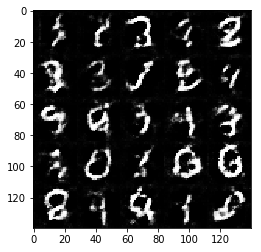

Epoch 1/2... Discriminator Loss: 1.7508... Generator Loss: 0.4850
Epoch 1/2... Discriminator Loss: 1.4494... Generator Loss: 0.5182
Epoch 1/2... Discriminator Loss: 1.6982... Generator Loss: 0.4833
Epoch 1/2... Discriminator Loss: 1.7330... Generator Loss: 0.5241
Epoch 1/2... Discriminator Loss: 1.6726... Generator Loss: 0.7843
Epoch 1/2... Discriminator Loss: 1.6751... Generator Loss: 0.6517
Epoch 1/2... Discriminator Loss: 1.6781... Generator Loss: 0.9584
Epoch 1/2... Discriminator Loss: 1.4560... Generator Loss: 0.8779
Epoch 1/2... Discriminator Loss: 2.0185... Generator Loss: 0.5363
Epoch 1/2... Discriminator Loss: 1.4275... Generator Loss: 0.7870


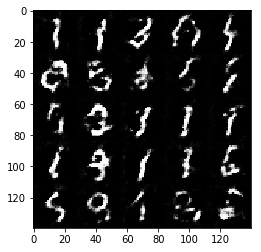

Epoch 1/2... Discriminator Loss: 1.7733... Generator Loss: 0.6023
Epoch 1/2... Discriminator Loss: 1.6874... Generator Loss: 0.6041
Epoch 1/2... Discriminator Loss: 1.6211... Generator Loss: 1.0251
Epoch 1/2... Discriminator Loss: 1.5480... Generator Loss: 0.7964
Epoch 1/2... Discriminator Loss: 1.7390... Generator Loss: 0.4099
Epoch 1/2... Discriminator Loss: 1.5492... Generator Loss: 0.7576
Epoch 1/2... Discriminator Loss: 1.8106... Generator Loss: 1.0616
Epoch 1/2... Discriminator Loss: 1.9216... Generator Loss: 0.6171
Epoch 1/2... Discriminator Loss: 1.6598... Generator Loss: 0.5071
Epoch 1/2... Discriminator Loss: 1.4101... Generator Loss: 0.6492


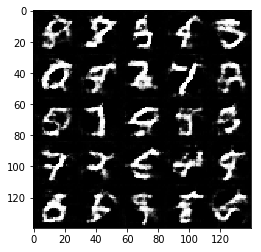

Epoch 1/2... Discriminator Loss: 1.5934... Generator Loss: 0.5340
Epoch 1/2... Discriminator Loss: 1.6810... Generator Loss: 0.6419
Epoch 1/2... Discriminator Loss: 1.7953... Generator Loss: 0.4068
Epoch 1/2... Discriminator Loss: 1.3873... Generator Loss: 0.6049
Epoch 1/2... Discriminator Loss: 1.7999... Generator Loss: 0.4116
Epoch 1/2... Discriminator Loss: 1.5322... Generator Loss: 0.8155
Epoch 1/2... Discriminator Loss: 1.6466... Generator Loss: 0.4284
Epoch 1/2... Discriminator Loss: 1.6796... Generator Loss: 0.3934
Epoch 1/2... Discriminator Loss: 1.5541... Generator Loss: 0.6760
Epoch 1/2... Discriminator Loss: 1.4154... Generator Loss: 0.5265


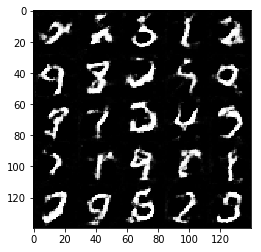

Epoch 1/2... Discriminator Loss: 1.3727... Generator Loss: 0.9591
Epoch 1/2... Discriminator Loss: 1.6032... Generator Loss: 0.5270
Epoch 1/2... Discriminator Loss: 1.7982... Generator Loss: 0.5444
Epoch 1/2... Discriminator Loss: 1.4593... Generator Loss: 1.0228
Epoch 1/2... Discriminator Loss: 1.5289... Generator Loss: 0.5798
Epoch 1/2... Discriminator Loss: 1.8110... Generator Loss: 0.4493
Epoch 1/2... Discriminator Loss: 1.7472... Generator Loss: 0.4754
Epoch 1/2... Discriminator Loss: 1.4868... Generator Loss: 0.7533
Epoch 1/2... Discriminator Loss: 1.6511... Generator Loss: 0.7104
Epoch 1/2... Discriminator Loss: 1.3963... Generator Loss: 1.0257


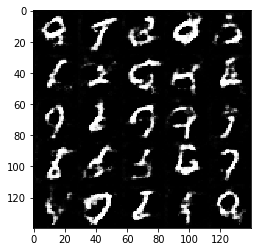

Epoch 1/2... Discriminator Loss: 1.7348... Generator Loss: 0.4566
Epoch 1/2... Discriminator Loss: 1.7054... Generator Loss: 0.4835
Epoch 1/2... Discriminator Loss: 1.3427... Generator Loss: 0.5723
Epoch 1/2... Discriminator Loss: 1.4530... Generator Loss: 0.6078
Epoch 1/2... Discriminator Loss: 1.6057... Generator Loss: 0.6709
Epoch 1/2... Discriminator Loss: 1.7063... Generator Loss: 0.6515
Epoch 1/2... Discriminator Loss: 1.5088... Generator Loss: 0.8070
Epoch 1/2... Discriminator Loss: 1.6052... Generator Loss: 0.9813
Epoch 1/2... Discriminator Loss: 1.6014... Generator Loss: 0.8616
Epoch 1/2... Discriminator Loss: 1.6246... Generator Loss: 0.5861


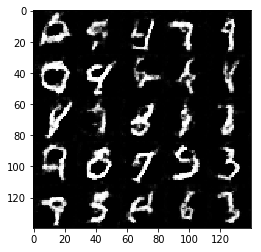

Epoch 1/2... Discriminator Loss: 1.5775... Generator Loss: 0.4805
Epoch 1/2... Discriminator Loss: 1.5187... Generator Loss: 0.7575
Epoch 1/2... Discriminator Loss: 1.4968... Generator Loss: 0.9716
Epoch 1/2... Discriminator Loss: 1.7760... Generator Loss: 0.5938
Epoch 1/2... Discriminator Loss: 1.5177... Generator Loss: 0.5652
Epoch 1/2... Discriminator Loss: 1.5117... Generator Loss: 0.3806
Epoch 1/2... Discriminator Loss: 1.8483... Generator Loss: 0.4635
Epoch 1/2... Discriminator Loss: 1.5448... Generator Loss: 1.0031
Epoch 1/2... Discriminator Loss: 1.7030... Generator Loss: 0.7807
Epoch 1/2... Discriminator Loss: 1.7356... Generator Loss: 0.5200


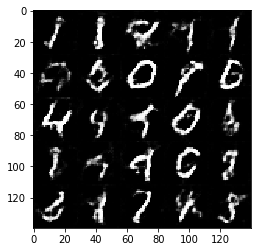

Epoch 1/2... Discriminator Loss: 1.4244... Generator Loss: 0.9766
Epoch 1/2... Discriminator Loss: 1.8126... Generator Loss: 0.3568
Epoch 1/2... Discriminator Loss: 1.7440... Generator Loss: 0.6177
Epoch 1/2... Discriminator Loss: 1.5825... Generator Loss: 0.7724
Epoch 1/2... Discriminator Loss: 1.5843... Generator Loss: 0.6775
Epoch 1/2... Discriminator Loss: 1.4784... Generator Loss: 0.8042
Epoch 1/2... Discriminator Loss: 1.5468... Generator Loss: 0.6302
Epoch 1/2... Discriminator Loss: 1.5364... Generator Loss: 0.5019
Epoch 1/2... Discriminator Loss: 1.3636... Generator Loss: 1.2338
Epoch 1/2... Discriminator Loss: 1.5855... Generator Loss: 1.1770


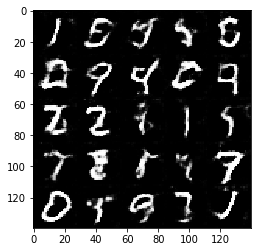

Epoch 1/2... Discriminator Loss: 1.5139... Generator Loss: 0.7226
Epoch 1/2... Discriminator Loss: 1.5337... Generator Loss: 0.7545
Epoch 1/2... Discriminator Loss: 1.7686... Generator Loss: 0.3124
Epoch 1/2... Discriminator Loss: 1.6051... Generator Loss: 0.5400
Epoch 1/2... Discriminator Loss: 1.9228... Generator Loss: 0.4284
Epoch 1/2... Discriminator Loss: 1.8943... Generator Loss: 1.2082
Epoch 1/2... Discriminator Loss: 1.4314... Generator Loss: 0.6511
Epoch 1/2... Discriminator Loss: 1.6067... Generator Loss: 0.7928
Epoch 1/2... Discriminator Loss: 1.5429... Generator Loss: 0.7804
Epoch 1/2... Discriminator Loss: 1.5023... Generator Loss: 0.5564


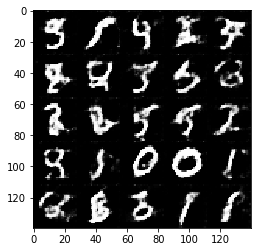

Epoch 1/2... Discriminator Loss: 1.3359... Generator Loss: 0.9482
Epoch 1/2... Discriminator Loss: 1.6414... Generator Loss: 0.8270
Epoch 1/2... Discriminator Loss: 1.6920... Generator Loss: 1.1117
Epoch 1/2... Discriminator Loss: 1.4153... Generator Loss: 0.7233
Epoch 1/2... Discriminator Loss: 1.5260... Generator Loss: 0.7717
Epoch 1/2... Discriminator Loss: 1.9144... Generator Loss: 0.5625
Epoch 1/2... Discriminator Loss: 1.5089... Generator Loss: 0.5551
Epoch 1/2... Discriminator Loss: 1.4182... Generator Loss: 0.6627
Epoch 1/2... Discriminator Loss: 1.6028... Generator Loss: 0.7034
Epoch 1/2... Discriminator Loss: 1.6752... Generator Loss: 0.8459


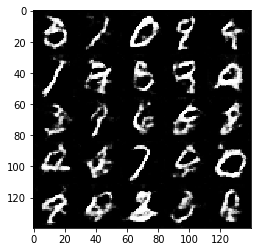

Epoch 1/2... Discriminator Loss: 1.7054... Generator Loss: 0.8680
Epoch 1/2... Discriminator Loss: 1.5165... Generator Loss: 0.4805
Epoch 1/2... Discriminator Loss: 1.5487... Generator Loss: 0.5837
Epoch 1/2... Discriminator Loss: 1.4131... Generator Loss: 0.7538
Epoch 1/2... Discriminator Loss: 1.5023... Generator Loss: 1.0669
Epoch 1/2... Discriminator Loss: 1.5488... Generator Loss: 0.5826
Epoch 1/2... Discriminator Loss: 1.4975... Generator Loss: 1.0651
Epoch 1/2... Discriminator Loss: 1.6135... Generator Loss: 0.4753
Epoch 1/2... Discriminator Loss: 1.6305... Generator Loss: 0.4793
Epoch 1/2... Discriminator Loss: 1.5259... Generator Loss: 0.6325


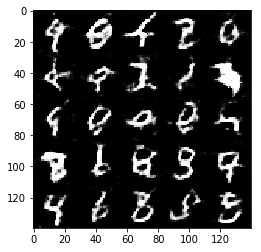

Epoch 1/2... Discriminator Loss: 1.7236... Generator Loss: 0.7332
Epoch 1/2... Discriminator Loss: 1.6428... Generator Loss: 0.4604
Epoch 1/2... Discriminator Loss: 1.5638... Generator Loss: 0.4991
Epoch 1/2... Discriminator Loss: 1.6789... Generator Loss: 0.3913
Epoch 1/2... Discriminator Loss: 1.5101... Generator Loss: 0.6700
Epoch 1/2... Discriminator Loss: 1.8037... Generator Loss: 0.6246
Epoch 1/2... Discriminator Loss: 1.5209... Generator Loss: 0.6555
Epoch 1/2... Discriminator Loss: 1.5185... Generator Loss: 0.9471
Epoch 1/2... Discriminator Loss: 1.8583... Generator Loss: 0.3964
Epoch 1/2... Discriminator Loss: 1.5893... Generator Loss: 0.6699


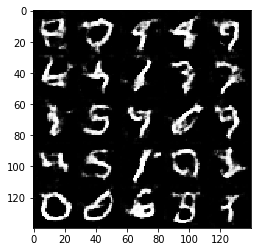

Epoch 1/2... Discriminator Loss: 1.7678... Generator Loss: 1.1629
Epoch 1/2... Discriminator Loss: 1.9000... Generator Loss: 0.4217
Epoch 1/2... Discriminator Loss: 1.5036... Generator Loss: 1.0716
Epoch 1/2... Discriminator Loss: 1.3867... Generator Loss: 0.5486
Epoch 1/2... Discriminator Loss: 1.6200... Generator Loss: 0.4840
Epoch 1/2... Discriminator Loss: 1.3758... Generator Loss: 0.9160
Epoch 1/2... Discriminator Loss: 1.5471... Generator Loss: 0.8018
Epoch 2/2... Discriminator Loss: 1.3493... Generator Loss: 0.7547
Epoch 2/2... Discriminator Loss: 1.5988... Generator Loss: 0.4314
Epoch 2/2... Discriminator Loss: 1.6052... Generator Loss: 0.9362


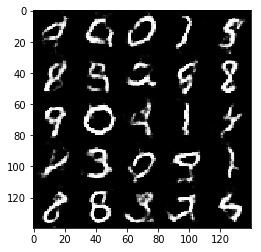

Epoch 2/2... Discriminator Loss: 1.4770... Generator Loss: 0.7658
Epoch 2/2... Discriminator Loss: 1.6952... Generator Loss: 0.8674
Epoch 2/2... Discriminator Loss: 1.3722... Generator Loss: 1.0016
Epoch 2/2... Discriminator Loss: 1.4146... Generator Loss: 0.5281
Epoch 2/2... Discriminator Loss: 1.5261... Generator Loss: 0.6632
Epoch 2/2... Discriminator Loss: 1.5206... Generator Loss: 0.4692
Epoch 2/2... Discriminator Loss: 1.5076... Generator Loss: 1.0518
Epoch 2/2... Discriminator Loss: 1.3818... Generator Loss: 0.7381
Epoch 2/2... Discriminator Loss: 1.5863... Generator Loss: 0.5619
Epoch 2/2... Discriminator Loss: 1.6414... Generator Loss: 0.5581


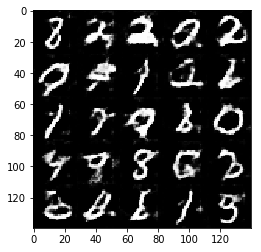

Epoch 2/2... Discriminator Loss: 1.8659... Generator Loss: 0.4398
Epoch 2/2... Discriminator Loss: 1.4956... Generator Loss: 0.7974
Epoch 2/2... Discriminator Loss: 1.7682... Generator Loss: 0.4078
Epoch 2/2... Discriminator Loss: 1.8303... Generator Loss: 0.4374
Epoch 2/2... Discriminator Loss: 1.5756... Generator Loss: 1.1523
Epoch 2/2... Discriminator Loss: 1.3406... Generator Loss: 0.8783
Epoch 2/2... Discriminator Loss: 1.7164... Generator Loss: 0.3688
Epoch 2/2... Discriminator Loss: 1.6165... Generator Loss: 0.7491
Epoch 2/2... Discriminator Loss: 1.6937... Generator Loss: 0.4355
Epoch 2/2... Discriminator Loss: 1.5253... Generator Loss: 1.1772


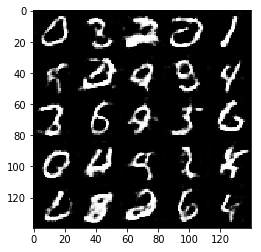

Epoch 2/2... Discriminator Loss: 1.4729... Generator Loss: 0.5965
Epoch 2/2... Discriminator Loss: 1.2665... Generator Loss: 0.6793
Epoch 2/2... Discriminator Loss: 1.5711... Generator Loss: 1.3312
Epoch 2/2... Discriminator Loss: 1.5090... Generator Loss: 0.6076
Epoch 2/2... Discriminator Loss: 1.5618... Generator Loss: 0.4709
Epoch 2/2... Discriminator Loss: 1.7178... Generator Loss: 0.7572
Epoch 2/2... Discriminator Loss: 1.6889... Generator Loss: 1.1304
Epoch 2/2... Discriminator Loss: 1.5853... Generator Loss: 0.8374
Epoch 2/2... Discriminator Loss: 1.5631... Generator Loss: 0.5465
Epoch 2/2... Discriminator Loss: 1.7564... Generator Loss: 0.3320


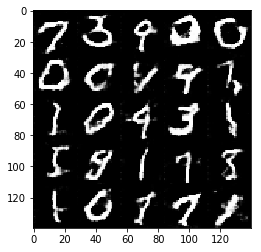

Epoch 2/2... Discriminator Loss: 1.5653... Generator Loss: 0.7014
Epoch 2/2... Discriminator Loss: 1.4361... Generator Loss: 0.7813
Epoch 2/2... Discriminator Loss: 1.7163... Generator Loss: 0.5113
Epoch 2/2... Discriminator Loss: 1.6064... Generator Loss: 0.6219
Epoch 2/2... Discriminator Loss: 1.5523... Generator Loss: 0.4831
Epoch 2/2... Discriminator Loss: 1.2500... Generator Loss: 0.7840
Epoch 2/2... Discriminator Loss: 1.2960... Generator Loss: 0.6533
Epoch 2/2... Discriminator Loss: 1.4293... Generator Loss: 0.7401
Epoch 2/2... Discriminator Loss: 1.5382... Generator Loss: 0.8517
Epoch 2/2... Discriminator Loss: 1.1671... Generator Loss: 0.7175


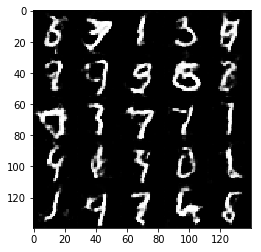

Epoch 2/2... Discriminator Loss: 1.5803... Generator Loss: 0.6426
Epoch 2/2... Discriminator Loss: 1.5275... Generator Loss: 0.9085
Epoch 2/2... Discriminator Loss: 1.5987... Generator Loss: 0.5609
Epoch 2/2... Discriminator Loss: 1.3705... Generator Loss: 0.5417
Epoch 2/2... Discriminator Loss: 1.6616... Generator Loss: 0.5183
Epoch 2/2... Discriminator Loss: 1.4982... Generator Loss: 0.6980
Epoch 2/2... Discriminator Loss: 1.4859... Generator Loss: 0.8200
Epoch 2/2... Discriminator Loss: 1.1830... Generator Loss: 0.9879
Epoch 2/2... Discriminator Loss: 1.7916... Generator Loss: 0.9916
Epoch 2/2... Discriminator Loss: 1.4651... Generator Loss: 0.8195


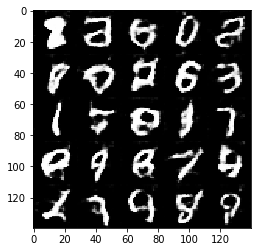

Epoch 2/2... Discriminator Loss: 1.7805... Generator Loss: 0.9609
Epoch 2/2... Discriminator Loss: 1.4706... Generator Loss: 0.9267
Epoch 2/2... Discriminator Loss: 1.5124... Generator Loss: 0.5473
Epoch 2/2... Discriminator Loss: 1.4495... Generator Loss: 0.5633
Epoch 2/2... Discriminator Loss: 1.6131... Generator Loss: 0.5114
Epoch 2/2... Discriminator Loss: 1.4572... Generator Loss: 0.6390
Epoch 2/2... Discriminator Loss: 1.6091... Generator Loss: 0.6764
Epoch 2/2... Discriminator Loss: 1.5797... Generator Loss: 0.9587
Epoch 2/2... Discriminator Loss: 1.5416... Generator Loss: 1.1154
Epoch 2/2... Discriminator Loss: 1.6155... Generator Loss: 0.6454


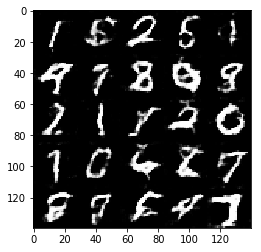

Epoch 2/2... Discriminator Loss: 1.6408... Generator Loss: 0.4121
Epoch 2/2... Discriminator Loss: 1.4826... Generator Loss: 1.1099
Epoch 2/2... Discriminator Loss: 1.6705... Generator Loss: 0.3521
Epoch 2/2... Discriminator Loss: 1.6531... Generator Loss: 0.8537
Epoch 2/2... Discriminator Loss: 1.5253... Generator Loss: 0.7046
Epoch 2/2... Discriminator Loss: 1.4667... Generator Loss: 0.8841
Epoch 2/2... Discriminator Loss: 1.9215... Generator Loss: 0.3270
Epoch 2/2... Discriminator Loss: 1.4445... Generator Loss: 1.0269
Epoch 2/2... Discriminator Loss: 1.8155... Generator Loss: 0.3057
Epoch 2/2... Discriminator Loss: 1.6828... Generator Loss: 0.4934


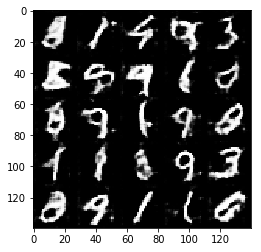

Epoch 2/2... Discriminator Loss: 1.6556... Generator Loss: 0.7438
Epoch 2/2... Discriminator Loss: 1.3628... Generator Loss: 0.7925
Epoch 2/2... Discriminator Loss: 1.5216... Generator Loss: 0.5326
Epoch 2/2... Discriminator Loss: 1.4989... Generator Loss: 0.5097
Epoch 2/2... Discriminator Loss: 1.6806... Generator Loss: 0.6701
Epoch 2/2... Discriminator Loss: 1.5718... Generator Loss: 0.6468
Epoch 2/2... Discriminator Loss: 1.5594... Generator Loss: 0.8588
Epoch 2/2... Discriminator Loss: 1.4164... Generator Loss: 0.9406
Epoch 2/2... Discriminator Loss: 1.7386... Generator Loss: 0.7563
Epoch 2/2... Discriminator Loss: 1.5503... Generator Loss: 0.7613


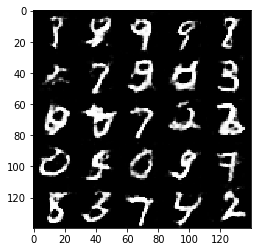

Epoch 2/2... Discriminator Loss: 1.3975... Generator Loss: 1.0860
Epoch 2/2... Discriminator Loss: 1.5525... Generator Loss: 0.7343
Epoch 2/2... Discriminator Loss: 1.7438... Generator Loss: 0.4908
Epoch 2/2... Discriminator Loss: 1.3445... Generator Loss: 0.7133
Epoch 2/2... Discriminator Loss: 1.5773... Generator Loss: 0.7402
Epoch 2/2... Discriminator Loss: 1.6121... Generator Loss: 0.7649
Epoch 2/2... Discriminator Loss: 1.6530... Generator Loss: 0.4836
Epoch 2/2... Discriminator Loss: 1.4862... Generator Loss: 0.4778
Epoch 2/2... Discriminator Loss: 1.5766... Generator Loss: 0.5943
Epoch 2/2... Discriminator Loss: 1.4152... Generator Loss: 0.5780


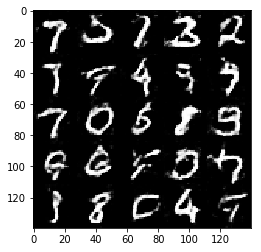

Epoch 2/2... Discriminator Loss: 1.7076... Generator Loss: 0.3514
Epoch 2/2... Discriminator Loss: 1.7931... Generator Loss: 1.0393
Epoch 2/2... Discriminator Loss: 1.4895... Generator Loss: 0.8811
Epoch 2/2... Discriminator Loss: 1.6008... Generator Loss: 0.6686
Epoch 2/2... Discriminator Loss: 1.5235... Generator Loss: 0.7531
Epoch 2/2... Discriminator Loss: 1.3832... Generator Loss: 0.7467
Epoch 2/2... Discriminator Loss: 1.5436... Generator Loss: 0.6239
Epoch 2/2... Discriminator Loss: 1.4343... Generator Loss: 0.7905
Epoch 2/2... Discriminator Loss: 1.4249... Generator Loss: 0.6010
Epoch 2/2... Discriminator Loss: 1.5691... Generator Loss: 0.6048


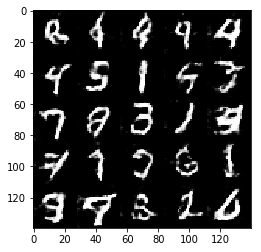

Epoch 2/2... Discriminator Loss: 1.6523... Generator Loss: 0.8278
Epoch 2/2... Discriminator Loss: 1.4690... Generator Loss: 0.9570
Epoch 2/2... Discriminator Loss: 1.4128... Generator Loss: 1.1078
Epoch 2/2... Discriminator Loss: 1.5674... Generator Loss: 0.5718
Epoch 2/2... Discriminator Loss: 1.5406... Generator Loss: 0.7086
Epoch 2/2... Discriminator Loss: 1.3758... Generator Loss: 1.1312
Epoch 2/2... Discriminator Loss: 1.5490... Generator Loss: 0.5617
Epoch 2/2... Discriminator Loss: 1.4779... Generator Loss: 0.5558
Epoch 2/2... Discriminator Loss: 1.5708... Generator Loss: 0.7079
Epoch 2/2... Discriminator Loss: 1.6424... Generator Loss: 0.4131


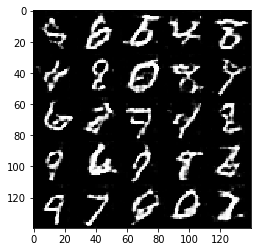

Epoch 2/2... Discriminator Loss: 1.4353... Generator Loss: 0.6987
Epoch 2/2... Discriminator Loss: 1.5518... Generator Loss: 0.7616
Epoch 2/2... Discriminator Loss: 1.6401... Generator Loss: 1.2751
Epoch 2/2... Discriminator Loss: 1.4247... Generator Loss: 0.9411
Epoch 2/2... Discriminator Loss: 1.7032... Generator Loss: 0.7163
Epoch 2/2... Discriminator Loss: 1.4952... Generator Loss: 1.0987
Epoch 2/2... Discriminator Loss: 1.6299... Generator Loss: 0.5278
Epoch 2/2... Discriminator Loss: 1.2664... Generator Loss: 0.7738
Epoch 2/2... Discriminator Loss: 1.5499... Generator Loss: 0.5065
Epoch 2/2... Discriminator Loss: 1.5487... Generator Loss: 0.6398


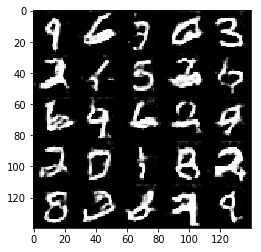

Epoch 2/2... Discriminator Loss: 1.7728... Generator Loss: 0.9963
Epoch 2/2... Discriminator Loss: 1.4270... Generator Loss: 0.9560
Epoch 2/2... Discriminator Loss: 1.4587... Generator Loss: 0.6913
Epoch 2/2... Discriminator Loss: 1.5081... Generator Loss: 0.4991
Epoch 2/2... Discriminator Loss: 1.3869... Generator Loss: 0.6268
Epoch 2/2... Discriminator Loss: 1.5697... Generator Loss: 0.8019
Epoch 2/2... Discriminator Loss: 1.3496... Generator Loss: 0.8921
Epoch 2/2... Discriminator Loss: 1.4522... Generator Loss: 1.2527
Epoch 2/2... Discriminator Loss: 1.3563... Generator Loss: 0.9058
Epoch 2/2... Discriminator Loss: 1.4929... Generator Loss: 0.6727


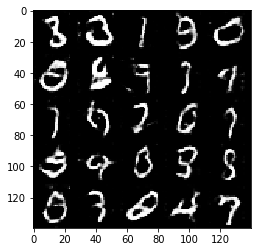

Epoch 2/2... Discriminator Loss: 1.5570... Generator Loss: 0.4326
Epoch 2/2... Discriminator Loss: 1.4022... Generator Loss: 0.5511
Epoch 2/2... Discriminator Loss: 1.2244... Generator Loss: 0.9688
Epoch 2/2... Discriminator Loss: 1.4998... Generator Loss: 0.7259
Epoch 2/2... Discriminator Loss: 1.4945... Generator Loss: 0.6274
Epoch 2/2... Discriminator Loss: 1.4434... Generator Loss: 1.3215
Epoch 2/2... Discriminator Loss: 1.3009... Generator Loss: 0.9570
Epoch 2/2... Discriminator Loss: 1.5142... Generator Loss: 1.2280
Epoch 2/2... Discriminator Loss: 1.5330... Generator Loss: 0.6883
Epoch 2/2... Discriminator Loss: 1.5419... Generator Loss: 1.0362


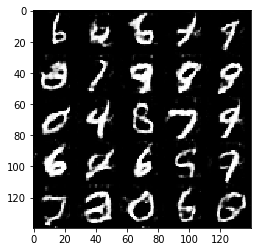

Epoch 2/2... Discriminator Loss: 1.5009... Generator Loss: 0.9024
Epoch 2/2... Discriminator Loss: 1.4263... Generator Loss: 0.8165
Epoch 2/2... Discriminator Loss: 1.4659... Generator Loss: 0.6256
Epoch 2/2... Discriminator Loss: 1.2773... Generator Loss: 0.6412
Epoch 2/2... Discriminator Loss: 1.4439... Generator Loss: 0.9085
Epoch 2/2... Discriminator Loss: 1.6690... Generator Loss: 0.4254
Epoch 2/2... Discriminator Loss: 1.3931... Generator Loss: 0.7216
Epoch 2/2... Discriminator Loss: 1.4638... Generator Loss: 0.6941
Epoch 2/2... Discriminator Loss: 1.5341... Generator Loss: 0.7704
Epoch 2/2... Discriminator Loss: 1.3373... Generator Loss: 0.7895


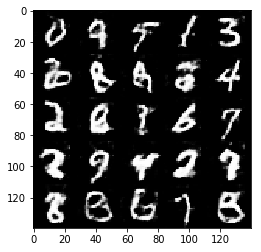

Epoch 2/2... Discriminator Loss: 1.5030... Generator Loss: 0.6650
Epoch 2/2... Discriminator Loss: 1.2664... Generator Loss: 0.7465
Epoch 2/2... Discriminator Loss: 1.4881... Generator Loss: 0.6235
Epoch 2/2... Discriminator Loss: 1.3043... Generator Loss: 0.9475
Epoch 2/2... Discriminator Loss: 1.3939... Generator Loss: 0.6815
Epoch 2/2... Discriminator Loss: 1.2980... Generator Loss: 0.8503
Epoch 2/2... Discriminator Loss: 1.5013... Generator Loss: 0.7392
Epoch 2/2... Discriminator Loss: 1.4602... Generator Loss: 0.7193
Epoch 2/2... Discriminator Loss: 1.3499... Generator Loss: 0.7028
Epoch 2/2... Discriminator Loss: 1.2797... Generator Loss: 0.8630


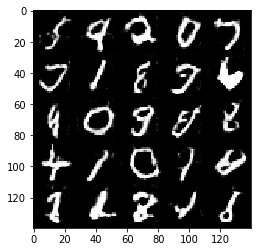

Epoch 2/2... Discriminator Loss: 1.5621... Generator Loss: 0.6816
Epoch 2/2... Discriminator Loss: 1.4028... Generator Loss: 0.6941
Epoch 2/2... Discriminator Loss: 1.3312... Generator Loss: 0.6177
Epoch 2/2... Discriminator Loss: 1.4196... Generator Loss: 0.7484
Epoch 2/2... Discriminator Loss: 1.4440... Generator Loss: 0.8169
Epoch 2/2... Discriminator Loss: 1.2844... Generator Loss: 0.7543
Epoch 2/2... Discriminator Loss: 1.5415... Generator Loss: 0.5570
Epoch 2/2... Discriminator Loss: 1.5627... Generator Loss: 0.8602
Epoch 2/2... Discriminator Loss: 1.3963... Generator Loss: 0.7338
Epoch 2/2... Discriminator Loss: 1.6594... Generator Loss: 0.4154


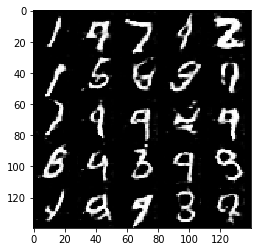

Epoch 2/2... Discriminator Loss: 1.5739... Generator Loss: 0.6391
Epoch 2/2... Discriminator Loss: 1.5825... Generator Loss: 0.9779
Epoch 2/2... Discriminator Loss: 1.3135... Generator Loss: 0.7133
Epoch 2/2... Discriminator Loss: 1.4474... Generator Loss: 0.8287
Epoch 2/2... Discriminator Loss: 1.5270... Generator Loss: 0.9409
Epoch 2/2... Discriminator Loss: 1.3870... Generator Loss: 0.7162
Epoch 2/2... Discriminator Loss: 1.6271... Generator Loss: 1.6237
Epoch 2/2... Discriminator Loss: 1.6437... Generator Loss: 0.5801
Epoch 2/2... Discriminator Loss: 1.4425... Generator Loss: 0.6436
Epoch 2/2... Discriminator Loss: 1.5749... Generator Loss: 0.6026


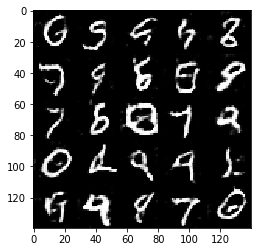

Epoch 2/2... Discriminator Loss: 1.2003... Generator Loss: 1.0383
Epoch 2/2... Discriminator Loss: 1.4385... Generator Loss: 0.6518
Epoch 2/2... Discriminator Loss: 1.8120... Generator Loss: 0.3106
Epoch 2/2... Discriminator Loss: 1.3064... Generator Loss: 0.7314
Epoch 2/2... Discriminator Loss: 1.2389... Generator Loss: 0.7105


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.9555... Generator Loss: 0.0423
Epoch 1/1... Discriminator Loss: 4.5544... Generator Loss: 0.0644
Epoch 1/1... Discriminator Loss: 4.2417... Generator Loss: 0.0622
Epoch 1/1... Discriminator Loss: 3.0877... Generator Loss: 0.2835
Epoch 1/1... Discriminator Loss: 2.9954... Generator Loss: 0.2340
Epoch 1/1... Discriminator Loss: 2.8138... Generator Loss: 0.3328
Epoch 1/1... Discriminator Loss: 2.9133... Generator Loss: 0.2305
Epoch 1/1... Discriminator Loss: 2.4214... Generator Loss: 0.4898
Epoch 1/1... Discriminator Loss: 2.3750... Generator Loss: 0.4100
Epoch 1/1... Discriminator Loss: 1.7947... Generator Loss: 0.4764


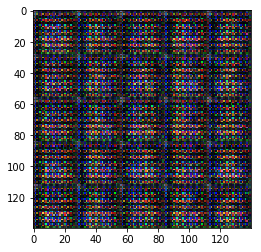

Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 1.3722
Epoch 1/1... Discriminator Loss: 1.7440... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 0.9501... Generator Loss: 1.1885
Epoch 1/1... Discriminator Loss: 1.6404... Generator Loss: 0.4053
Epoch 1/1... Discriminator Loss: 2.0895... Generator Loss: 0.4820
Epoch 1/1... Discriminator Loss: 2.1161... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 2.2582... Generator Loss: 0.4344
Epoch 1/1... Discriminator Loss: 2.5400... Generator Loss: 0.4506


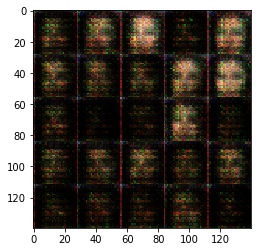

Epoch 1/1... Discriminator Loss: 2.0998... Generator Loss: 0.4546
Epoch 1/1... Discriminator Loss: 2.3898... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.9385... Generator Loss: 0.5194
Epoch 1/1... Discriminator Loss: 1.9648... Generator Loss: 0.4887
Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 0.9337
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 1.6891... Generator Loss: 0.5280
Epoch 1/1... Discriminator Loss: 1.9162... Generator Loss: 0.4151
Epoch 1/1... Discriminator Loss: 2.1100... Generator Loss: 0.3325
Epoch 1/1... Discriminator Loss: 2.1695... Generator Loss: 0.3903


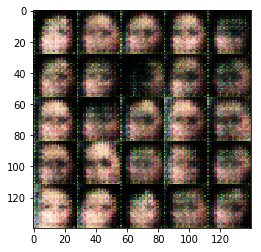

Epoch 1/1... Discriminator Loss: 2.0039... Generator Loss: 0.4042
Epoch 1/1... Discriminator Loss: 1.7156... Generator Loss: 0.5216
Epoch 1/1... Discriminator Loss: 1.8601... Generator Loss: 0.4584
Epoch 1/1... Discriminator Loss: 1.9790... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 2.0558... Generator Loss: 0.4247
Epoch 1/1... Discriminator Loss: 1.6223... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.5265... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.7049... Generator Loss: 0.5470
Epoch 1/1... Discriminator Loss: 1.7641... Generator Loss: 0.5202
Epoch 1/1... Discriminator Loss: 1.8035... Generator Loss: 0.4572


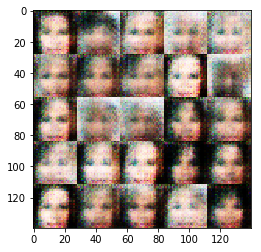

Epoch 1/1... Discriminator Loss: 1.8248... Generator Loss: 0.5443
Epoch 1/1... Discriminator Loss: 1.6981... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 2.2284... Generator Loss: 0.3314
Epoch 1/1... Discriminator Loss: 1.8312... Generator Loss: 0.4715
Epoch 1/1... Discriminator Loss: 1.7559... Generator Loss: 0.4391
Epoch 1/1... Discriminator Loss: 1.9610... Generator Loss: 0.3989
Epoch 1/1... Discriminator Loss: 1.9215... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 1.7204... Generator Loss: 0.5501
Epoch 1/1... Discriminator Loss: 1.5794... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.9550... Generator Loss: 0.8001


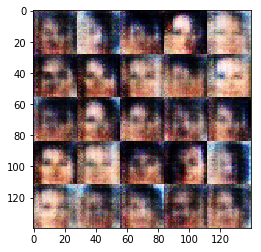

Epoch 1/1... Discriminator Loss: 1.9868... Generator Loss: 0.3987
Epoch 1/1... Discriminator Loss: 1.8093... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.7680... Generator Loss: 0.5773
Epoch 1/1... Discriminator Loss: 1.8804... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.6455... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.6770... Generator Loss: 0.6161
Epoch 1/1... Discriminator Loss: 1.8159... Generator Loss: 0.4106
Epoch 1/1... Discriminator Loss: 1.8659... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.7516... Generator Loss: 0.5317
Epoch 1/1... Discriminator Loss: 1.8327... Generator Loss: 0.8399


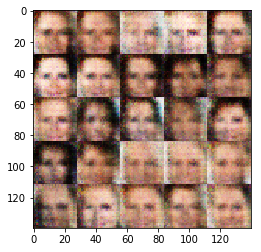

Epoch 1/1... Discriminator Loss: 1.8312... Generator Loss: 0.5328
Epoch 1/1... Discriminator Loss: 1.9800... Generator Loss: 0.5766
Epoch 1/1... Discriminator Loss: 1.9283... Generator Loss: 0.3903
Epoch 1/1... Discriminator Loss: 1.6390... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.8241... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.5604
Epoch 1/1... Discriminator Loss: 2.0768... Generator Loss: 0.3745
Epoch 1/1... Discriminator Loss: 1.8069... Generator Loss: 0.5830
Epoch 1/1... Discriminator Loss: 1.8589... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.7889... Generator Loss: 0.7093


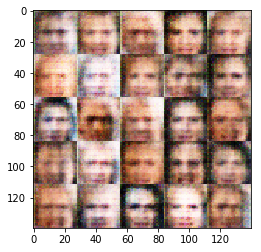

Epoch 1/1... Discriminator Loss: 1.5260... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.8932... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.8922... Generator Loss: 0.5667
Epoch 1/1... Discriminator Loss: 2.1507... Generator Loss: 0.4874
Epoch 1/1... Discriminator Loss: 1.7234... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.6245... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 1.9977... Generator Loss: 0.5139
Epoch 1/1... Discriminator Loss: 1.6165... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.6358... Generator Loss: 0.6208


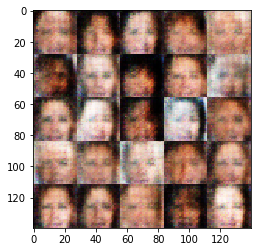

Epoch 1/1... Discriminator Loss: 1.9345... Generator Loss: 0.4835
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.7711... Generator Loss: 0.4287
Epoch 1/1... Discriminator Loss: 1.8021... Generator Loss: 0.4977
Epoch 1/1... Discriminator Loss: 1.5785... Generator Loss: 0.5381
Epoch 1/1... Discriminator Loss: 1.7899... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.7544... Generator Loss: 0.4831
Epoch 1/1... Discriminator Loss: 1.8200... Generator Loss: 0.5182
Epoch 1/1... Discriminator Loss: 1.5278... Generator Loss: 1.1067
Epoch 1/1... Discriminator Loss: 1.6120... Generator Loss: 0.4820


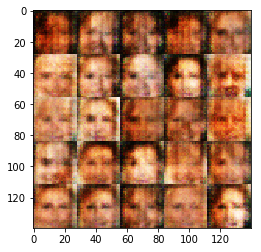

Epoch 1/1... Discriminator Loss: 1.5552... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.9328... Generator Loss: 0.5161
Epoch 1/1... Discriminator Loss: 1.6125... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.5847... Generator Loss: 0.5449
Epoch 1/1... Discriminator Loss: 1.6570... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.6604... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 1.0799
Epoch 1/1... Discriminator Loss: 1.5558... Generator Loss: 0.7941


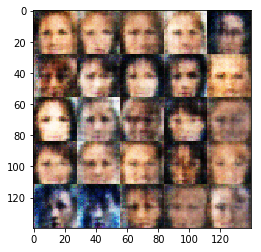

Epoch 1/1... Discriminator Loss: 1.7493... Generator Loss: 0.5641
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.6195... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.6582... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.6957... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.8150... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.6235... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.6847... Generator Loss: 0.5696
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.5815... Generator Loss: 0.7094


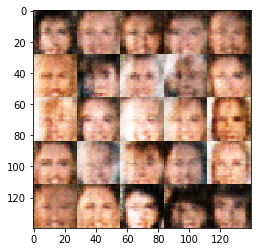

Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.6986... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 1.8448... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.7234... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.5189... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 1.5831... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.7476... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.7363... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.5525... Generator Loss: 0.7277


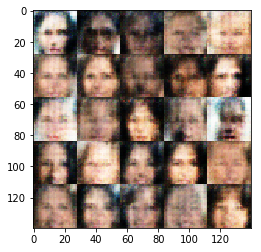

Epoch 1/1... Discriminator Loss: 1.7486... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.6914... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.6963... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.5839... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.9193... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.7160... Generator Loss: 0.6050
Epoch 1/1... Discriminator Loss: 1.5632... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.7344... Generator Loss: 0.5781
Epoch 1/1... Discriminator Loss: 1.6738... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.6284... Generator Loss: 0.7835


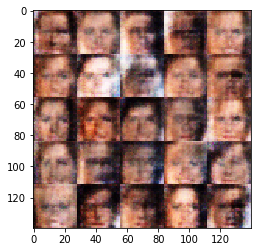

Epoch 1/1... Discriminator Loss: 1.6256... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.7833... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 1.6206... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.9045... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.7029... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 1.5571... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 1.6219... Generator Loss: 0.7336


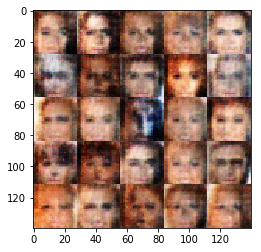

Epoch 1/1... Discriminator Loss: 1.5843... Generator Loss: 1.0414
Epoch 1/1... Discriminator Loss: 1.6451... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.5155... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 1.5056... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.5325... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.5737... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.6126... Generator Loss: 0.6287


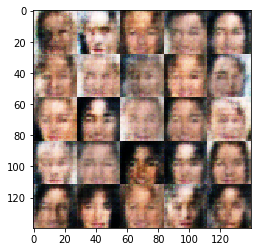

Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.6483... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.7318... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.7237... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.8069... Generator Loss: 0.5576
Epoch 1/1... Discriminator Loss: 1.8579... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.5557... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.6011... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.4961... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.7114... Generator Loss: 0.7448


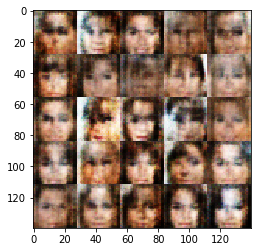

Epoch 1/1... Discriminator Loss: 1.6956... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.5914... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.7454
Epoch 1/1... Discriminator Loss: 1.6429... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.5964... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.5219... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.5933... Generator Loss: 0.4737
Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 0.7694


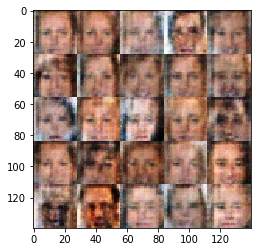

Epoch 1/1... Discriminator Loss: 1.5124... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.7811... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 1.6617... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.6454... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.6731... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.6498... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 1.8017... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 1.7344... Generator Loss: 0.5659
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.7198


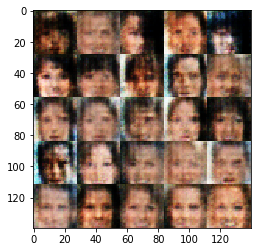

Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.7186... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.6058... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.5928... Generator Loss: 0.9076
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.8179... Generator Loss: 0.7301


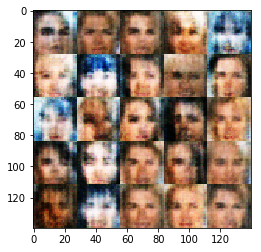

Epoch 1/1... Discriminator Loss: 1.5963... Generator Loss: 0.5458
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 1.5420... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.6178... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.6525... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.6012... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.9209
Epoch 1/1... Discriminator Loss: 1.6575... Generator Loss: 0.6745


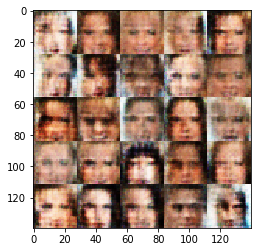

Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 1.7209... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.5566... Generator Loss: 0.6575


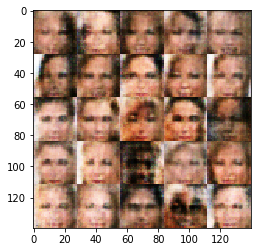

Epoch 1/1... Discriminator Loss: 1.5801... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.5192... Generator Loss: 0.9367
Epoch 1/1... Discriminator Loss: 1.6478... Generator Loss: 0.4839
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 1.8260... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.5565... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.5799... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.8788... Generator Loss: 0.5000
Epoch 1/1... Discriminator Loss: 1.5079... Generator Loss: 0.6805


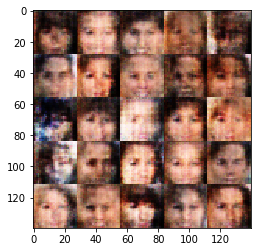

Epoch 1/1... Discriminator Loss: 1.6050... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.5081... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.6596... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.5536... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.5634... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.6531... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.5242... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.8786
Epoch 1/1... Discriminator Loss: 1.5979... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.5617... Generator Loss: 0.8250


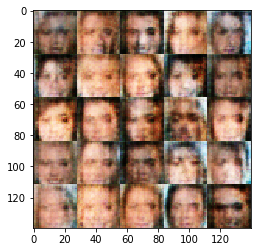

Epoch 1/1... Discriminator Loss: 1.6038... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.5059... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.5654... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.6189... Generator Loss: 0.5478
Epoch 1/1... Discriminator Loss: 1.5744... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.6526... Generator Loss: 0.6044
Epoch 1/1... Discriminator Loss: 1.6507... Generator Loss: 0.8644
Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.7579... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.5684... Generator Loss: 0.6284


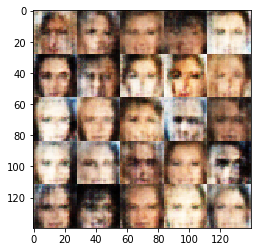

Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 1.9033... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.5526... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.7246... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.5692... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.6004... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.9694


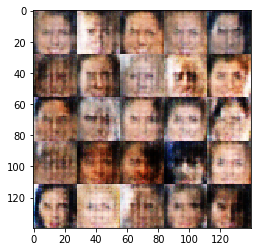

Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.5524... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.5327
Epoch 1/1... Discriminator Loss: 1.6648... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.6095... Generator Loss: 0.5816
Epoch 1/1... Discriminator Loss: 1.6207... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.5900... Generator Loss: 0.5248
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.6550... Generator Loss: 0.5569


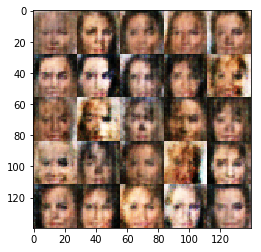

Epoch 1/1... Discriminator Loss: 1.6101... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.6571... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.5871
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.4961... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.6958... Generator Loss: 0.5142
Epoch 1/1... Discriminator Loss: 1.7367... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 1.5515... Generator Loss: 0.8446


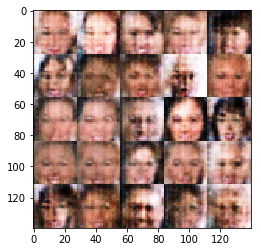

Epoch 1/1... Discriminator Loss: 1.5502... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.5724... Generator Loss: 1.2017
Epoch 1/1... Discriminator Loss: 1.5954... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.5453... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 1.5502... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.5381... Generator Loss: 0.7312


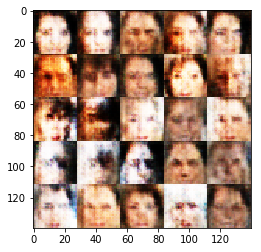

Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.8828
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.5439... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.5722... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.6417... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.8108


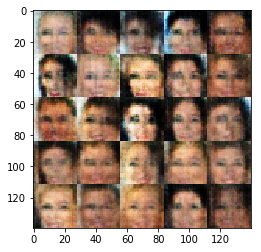

Epoch 1/1... Discriminator Loss: 1.5740... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.8809
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.6796... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.5991... Generator Loss: 0.5485
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.6654... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.5829... Generator Loss: 0.6238


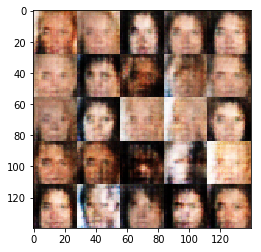

Epoch 1/1... Discriminator Loss: 1.5706... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.6851... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.5590... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.5588... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.5391... Generator Loss: 0.6402


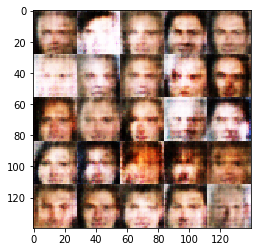

Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.9829
Epoch 1/1... Discriminator Loss: 1.5074... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.5327... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.6934... Generator Loss: 0.5506
Epoch 1/1... Discriminator Loss: 1.5377... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.5911... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.7701


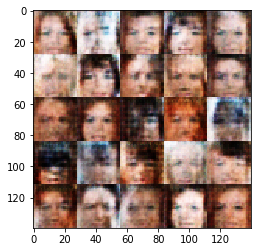

Epoch 1/1... Discriminator Loss: 1.5555... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.7363... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.6490... Generator Loss: 0.5618
Epoch 1/1... Discriminator Loss: 1.6681... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 1.6939... Generator Loss: 0.5711


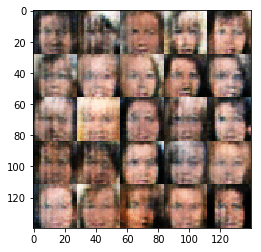

Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.5534... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.5354... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 1.6839... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.6300... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.5183... Generator Loss: 0.7513


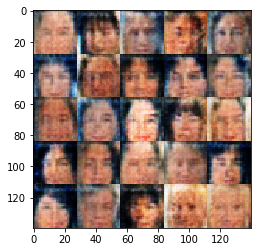

Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.5586... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.6530... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.4965... Generator Loss: 0.8760


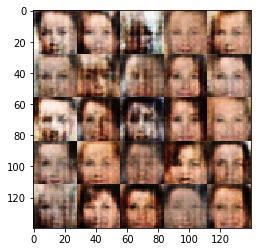

Epoch 1/1... Discriminator Loss: 1.5578... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.6263... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.5372... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.5304... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 1.5702... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.6308


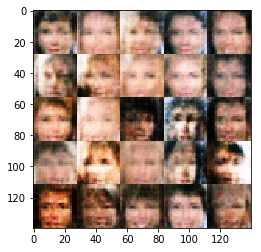

Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.8925
Epoch 1/1... Discriminator Loss: 1.5783... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.5653... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.5049... Generator Loss: 0.4783
Epoch 1/1... Discriminator Loss: 1.5206... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 1.5391... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.5081... Generator Loss: 0.7659


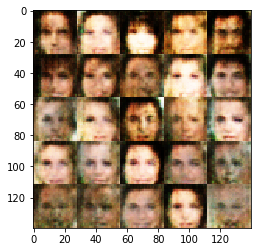

Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.5473... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.9554
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.5430... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.8359


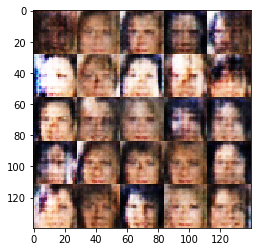

Epoch 1/1... Discriminator Loss: 1.8271... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.5563... Generator Loss: 0.5504
Epoch 1/1... Discriminator Loss: 1.5333... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.5527... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.4867... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 0.5793
Epoch 1/1... Discriminator Loss: 1.5174... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.8634
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.8920


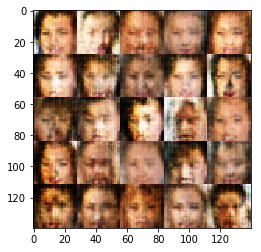

Epoch 1/1... Discriminator Loss: 1.5350... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.5514... Generator Loss: 0.4955
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.5074... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.6267... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 0.7498


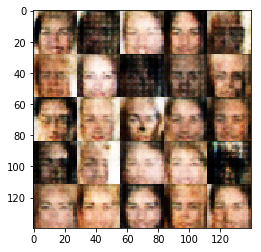

Epoch 1/1... Discriminator Loss: 1.6317... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.6688... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 1.5308... Generator Loss: 0.5666
Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.5467... Generator Loss: 0.5558
Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.5734... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.5366... Generator Loss: 0.5906
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.6679


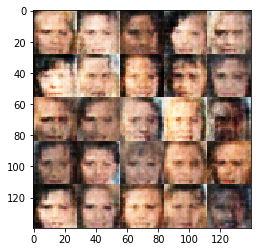

Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.8624
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.9119
Epoch 1/1... Discriminator Loss: 1.5200... Generator Loss: 0.5116
Epoch 1/1... Discriminator Loss: 1.6853... Generator Loss: 0.5204
Epoch 1/1... Discriminator Loss: 1.5298... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.5392
Epoch 1/1... Discriminator Loss: 1.5713... Generator Loss: 0.6394


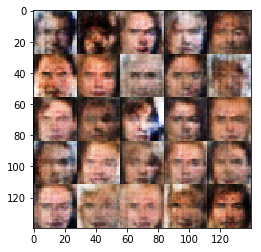

Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.6333... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.5370... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.5532... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.8597


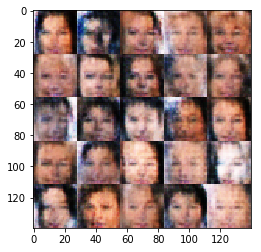

Epoch 1/1... Discriminator Loss: 1.5742... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.9248
Epoch 1/1... Discriminator Loss: 1.5827... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.5660... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.5528... Generator Loss: 0.5720
Epoch 1/1... Discriminator Loss: 1.5582... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.7494


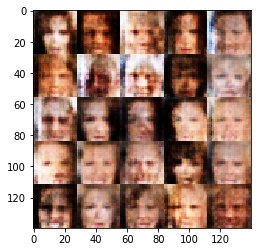

Epoch 1/1... Discriminator Loss: 1.5206... Generator Loss: 0.5691
Epoch 1/1... Discriminator Loss: 1.5577... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.4990... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.6395


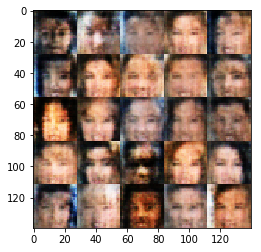

Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.5542... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.5027... Generator Loss: 1.0246
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.5356... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.5256... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.5353... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.6386... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.6526... Generator Loss: 0.6358


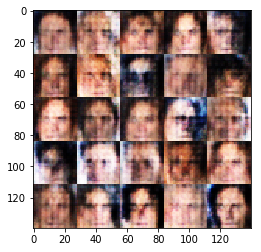

Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.5534... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.5557... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.5210... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.7514


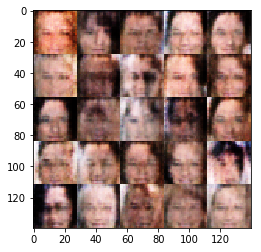

Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.5302
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 1.1509
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 1.0166
Epoch 1/1... Discriminator Loss: 1.6882... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.5668... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.5343
Epoch 1/1... Discriminator Loss: 1.6301... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.6329... Generator Loss: 0.8154


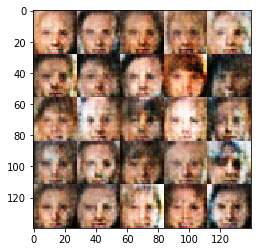

Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.5689
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.5433... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.5247... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.5385... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.7751


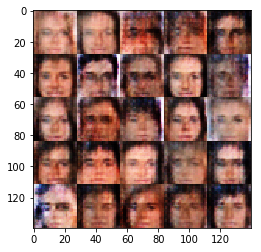

Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.5682... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.5922... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.6271... Generator Loss: 0.7581


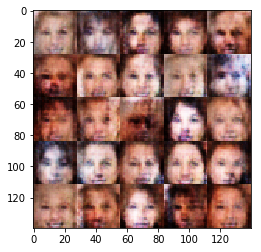

Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.5457... Generator Loss: 0.5684
Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 1.0989
Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.5790
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.5548... Generator Loss: 0.5689


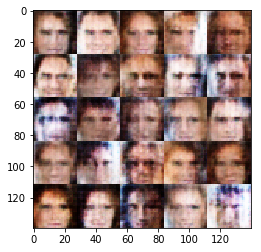

Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.5376
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.6129... Generator Loss: 0.9609
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.5904... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.5418... Generator Loss: 0.9755
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.6899


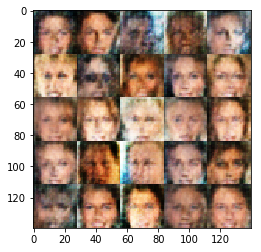

Epoch 1/1... Discriminator Loss: 1.5544... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.9485
Epoch 1/1... Discriminator Loss: 1.5697... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.5681... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.9133
Epoch 1/1... Discriminator Loss: 1.5552... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.5498... Generator Loss: 0.6447


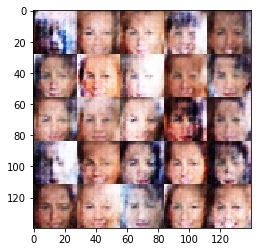

Epoch 1/1... Discriminator Loss: 1.6252... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.5075... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.6175... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.7216... Generator Loss: 0.6161
Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 0.6321


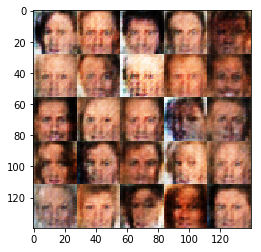

Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 1.6881... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.5650... Generator Loss: 1.0360
Epoch 1/1... Discriminator Loss: 1.5367... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 1.5539... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.7074... Generator Loss: 0.5641
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.8572


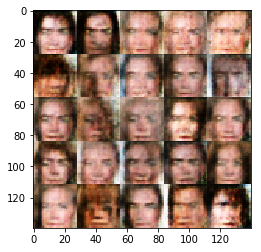

Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 0.9508
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.5105... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.7337


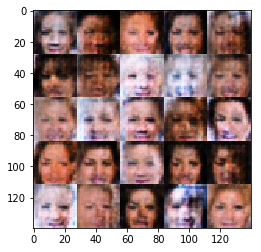

Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.9122
Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.9061
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.5155... Generator Loss: 0.8976


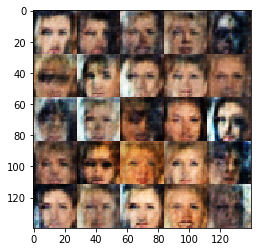

Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.5253... Generator Loss: 0.5059
Epoch 1/1... Discriminator Loss: 1.5526... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.5178... Generator Loss: 1.0278
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 1.0299


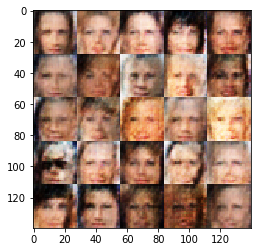

Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.9602
Epoch 1/1... Discriminator Loss: 1.5363... Generator Loss: 0.5487
Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.5217
Epoch 1/1... Discriminator Loss: 1.5808... Generator Loss: 0.5291
Epoch 1/1... Discriminator Loss: 1.5306... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.6382... Generator Loss: 0.5917


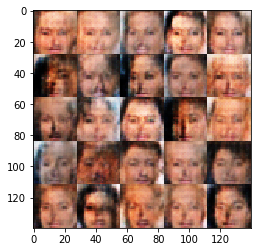

Epoch 1/1... Discriminator Loss: 1.5621... Generator Loss: 0.5549
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.6234... Generator Loss: 1.0112
Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 0.9896
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.8817


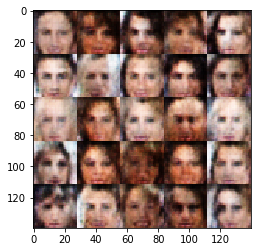

Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 1.0182
Epoch 1/1... Discriminator Loss: 1.5088... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.6311
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.9831


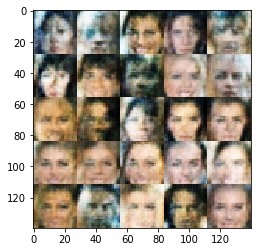

Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.4999... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.9671
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.5792
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.7655


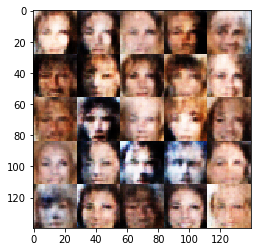

Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.5538... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.6992... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 0.5430
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.5025... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.8464


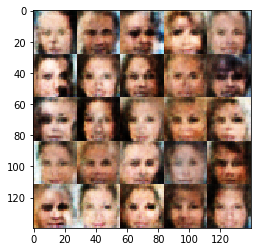

Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.6038... Generator Loss: 0.6552


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.